# Solving PDEs with Jax - Problem 8
## Description

### Average time of execution 
Between 2 and 3 minutes on GPU

### PDE
We will try to solve the problem 8 of the article https://ieeexplore.ieee.org/document/712178  

$\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}= f(x,y)$ on $\Omega = [0,1]^2$  
where $f(x, y)=\sin(\pi x)(2-\pi^2y^2+2y^3\sin(\pi x))$   

### Boundary conditions    
$\psi(0,y)=\psi(1,y)=\psi(x,0)=0$ and $\frac{\partial \psi}{\partial y}(x,1)=2\sin(\pi x)$           

### Analytical solution
The analytical solution is $\psi(x, y)=y^2sin(\pi x)$  

### Approximated solution
We want find a solution $\psi(x,y)=A(x,y)+F(x,y)N(x,y)$
s.t:  
$F(x,y)=\sin(x-1)\sin(y-1)\sin(x)\sin(y)$ 
$A(x,y)=y\sin(\pi x)$   

### Loss function
The loss to minimize here is $\mathcal{L} = ||\Delta \psi(x,y) +\psi(x,y)\cdot\frac{\partial \psi(x,y)}{\partial y}-f(x,y) ||_2$  


# Libraries

In [1]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot
import numpy
%matplotlib inline

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Parameters

In [2]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 2        # Input dimension (x1, x2)
parameters['n_targets'] = 1         # Output dimension. It's a complex number (y1 + j*y2)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]

# Training parameters
parameters['learning_rate'] = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 5000)
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 50000
parameters['report_steps'] = 1000
parameters['options'] = 1           # 1: we start a new training. 2: We continue the last training. 
                                    # Other cases: We just load the last training

# Data parameters
parameters['batch_size'] = 100
parameters['domain_bounds'] = jax.numpy.column_stack(([0.0, 0.0], [1.0, 1.0]))   # minimal and maximal value of each axis (x, y)

# Neural network

In [3]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position (x,y) using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the domain
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- neural network output 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        output = jax.numpy.dot(inputs, weights.T)+bias
        return output


# Operators

In [4]:
class PDE_operators2d:
    """
        Class with the operators used to solve the PDE
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, function):
        self.function = function

    # Compute the two dimensional laplacian
    def laplacian_2d(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @functools.partial(jax.jit)    
        def action(params,x,y):
            u_xx = jax.jacfwd(jax.jacfwd(fun, 1), 1)(params,x,y)
            u_yy = jax.jacfwd(jax.jacfwd(fun, 2), 2)(params,x,y)
            return u_xx + u_yy
        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
        return laplacian.reshape((-1,1))

    # Compute the partial derivative in y
    @functools.partial(jax.jit, static_argnums=(0,))    
    def du_dy(self,params,inputs):
        fun = lambda params,x,y: self.function(params, x,y)
        @functools.partial(jax.jit)    
        def action(params,x,y):
            u_y = jax.jacfwd(fun, 2)(params,x,y)
            return u_y
        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        return vec_fun(params, inputs[:,0], inputs[:,1]).reshape((-1,1))

# Physics Informed Neural Network

In [5]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network and the optimizer selected to do gradient descent
    """
    def __init__(self, NN_evaluation, optimizer):
        self.optimizer = optimizer
        self.operators=PDE_operators2d(self.spatial_solution2d)
        self.laplacian=self.operators.laplacian_2d
        self.NN_evaluation=NN_evaluation
        self.dsol_dy=self.operators.du_dy


    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def spatial_solution2d(self, params, inputX, inputY):
        """
        Compute the complex solution of the PDE on the points (x, y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the domain
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the domain
        Returns
        -------
        applied_solution : jax.numpy.array[batch_size]
            -- PINN solution applied to inputs. return F_NN_plus_A, a complex array
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        F = self.F_function(inputX,inputY)
        A = self.A_function(inputX,inputY)
        F_NN_plus_A = jax.numpy.add(jax.numpy.multiply(F, NN), A)
        return F_NN_plus_A


    # Definition of the function A(x, y) mentioned above   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def A_function(self, inputX, inputY):
        """
        Compute A(x, y) on the inputs
        Parameters
        ----------
        inputX : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        inputY : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        A_output : jax.numpy.array[batch_size]
            -- A(x, y) applied to inputs
        """
        A_output = jax.numpy.multiply(inputY,jax.numpy.sin(jax.numpy.pi*inputX))
        return A_output.reshape(-1,1)


    # Definition of the function F(x, y) mentioned above   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def F_function(self, inputX, inputY):
        """
        Compute F(x, y) on the inputs
        Parameters
        ----------
        inputX : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        inputY : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        F_output : jax.numpy.array[batch_size]
            -- F(x, y) applied to inputs
        """
        F1 = jax.numpy.multiply(jax.numpy.sin(inputX), jax.numpy.sin(inputX - 1))
        F2 = jax.numpy.multiply(jax.numpy.sin(inputY), jax.numpy.sin(inputY - 1))
        F_output = jax.numpy.multiply(F1, F2)
        return F_output.reshape((-1,1))


    # Definition of the function f(x, y) mentioned above   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def exact_function(self, inputs):
        """
        Compute f(x, y) on the inputs
        Parameters
        ----------
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        exact_output : jax.numpy.array[batch_size]
            -- f(x, y) applied to inputs
        """
        exact_output = jax.numpy.multiply(jax.numpy.sin(jax.numpy.pi*inputs[:,0]),2-jax.numpy.pi**2*inputs[:,1]**2+2*inputs[:,1]**3*jax.numpy.sin(jax.numpy.pi*inputs[:,0])).reshape(-1,1) 

        return exact_output


    # Definition of the pde mentioned above   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def pde_function(self, params, inputs):
        """
        Compute the pde on the inputs
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        pde_value : jax.numpy.array[batch_size]
            -- pde applied to inputs
        """
        laplacian=self.laplacian(params, inputs)
        dsol_dy_values=self.dsol_dy(params, inputs)
        pde_value = laplacian+jax.numpy.multiply(self.spatial_solution2d(params,inputs[:,0],inputs[:,1]),dsol_dy_values)

        return pde_value


    # Definition of the loss function mentioned above   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def loss_function(self, params, inputs):
        """
        Compute the loss of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) points from the domain
        Returns
        -------
        loss_value : a float64
            -- loss function applied to inputs
        """
        residual = self.pde_function(params, inputs) - self.exact_function(inputs)
        loss_value = (jax.numpy.linalg.norm(residual)**2)/inputs.shape[0]
        
        return loss_value


    # Make one train step   
    @functools.partial(jax.jax.jit, static_argnums = (0, ))    
    def train_step(self, params, opt_state, inputs):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax library
            -- state(hystorical) of the gradient descent
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x, y) inputs from the domain
        Returns
        -------
        loss : a float64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        """
        loss, gradient = jax.value_and_grad(self.loss_function)(params, inputs)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state


# Analytical solution

In [6]:
def analytical_solution(inputs):
    analytical = jax.numpy.multiply(inputs[:,1]**2,jax.numpy.sin(jax.numpy.pi*inputs[:,0]))
    return analytical

# Dataset creation

In [7]:
x = jax.numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], int(jax.numpy.sqrt(parameters['batch_size'])))
y = jax.numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], int(jax.numpy.sqrt(parameters['batch_size'])))
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
XY_train = jax.numpy.column_stack((x, y))

# Dataset plot

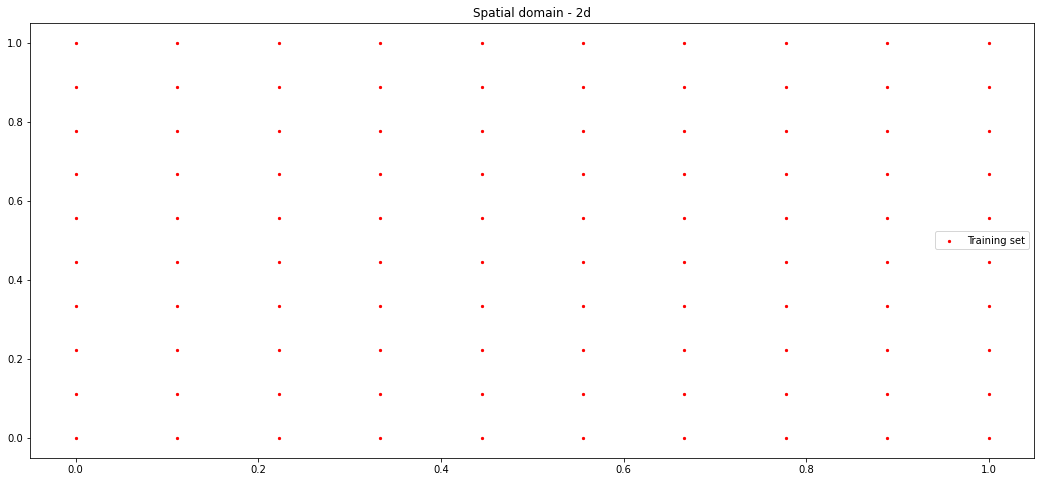

In [8]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 8.0)
title = ax.set_title('Spatial domain - 2d')
graph = matplotlib.pyplot.scatter(XY_train[:,0], XY_train[:,1], color = 'red', s = 5)
__ = ax.legend(['Training set'])

matplotlib.pyplot.savefig('./Images/domain2d.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Model initialization

In [9]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluation function
solver = PINN(NN_eval, parameters['optimizer'])
opt_state = parameters['optimizer'].init(params)

# Training

In [10]:
loss_history = []
print("Training start")
if parameters['options'] == 1:            # start a new training
    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):
        loss, params, opt_state = solver.train_step(params, opt_state, XY_train)

        loss_history.append(float(loss))

        if (ibatch%parameters['report_steps']) == parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if loss <= numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_pde8", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_pde8", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_pde8", "wb"))
        
elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_pde8", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_pde8", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_pde8", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch, parameters['maximum_num_epochs']+1):
        loss, params, opt_state = solver.train_step(params, opt_state, XY_train)

        loss_history.append(float(loss))

        if (ibatch%parameters['report_steps']) == parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), loss.item())

        if loss <= numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_pde8", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_pde8", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_pde8", "wb"))
else:
    params = pickle.load(open("./Checkpoints/params_pde8", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_pde8", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_pde8", "rb"))

Training start
Epoch n°1000:  8.996744948953828e-06
Epoch n°2000:  2.219810121351599e-06
Epoch n°3000:  1.2568510975621638e-06
Epoch n°4000:  1.2227255827880005e-06
Epoch n°5000:  7.3591651923240855e-06
Epoch n°6000:  8.635102363678335e-07
Epoch n°7000:  8.4675303236561e-07
Epoch n°8000:  8.206784484513398e-07
Epoch n°9000:  7.823239540206966e-07
Epoch n°10000:  7.288279485782279e-07
Epoch n°11000:  6.587772540876832e-07
Epoch n°12000:  5.735631226414194e-07
Epoch n°13000:  4.79551475831205e-07
Epoch n°14000:  3.855918629539184e-07
Epoch n°15000:  2.981402363883973e-07
Epoch n°16000:  2.2136553211593646e-07
Epoch n°17000:  1.5873247162225042e-07
Epoch n°18000:  1.1247808116055938e-07
Epoch n°19000:  8.437787139612897e-08
Epoch n°20000:  6.668089513349021e-08
Epoch n°21000:  5.273306325874463e-08
Epoch n°22000:  4.317769757205502e-08
Epoch n°23000:  3.622390102331593e-08
Epoch n°24000:  3.213724614699126e-08
Epoch n°25000:  2.696980128036525e-08
Epoch n°26000:  2.5750825126357348e-08
Ep

# Loss function plot

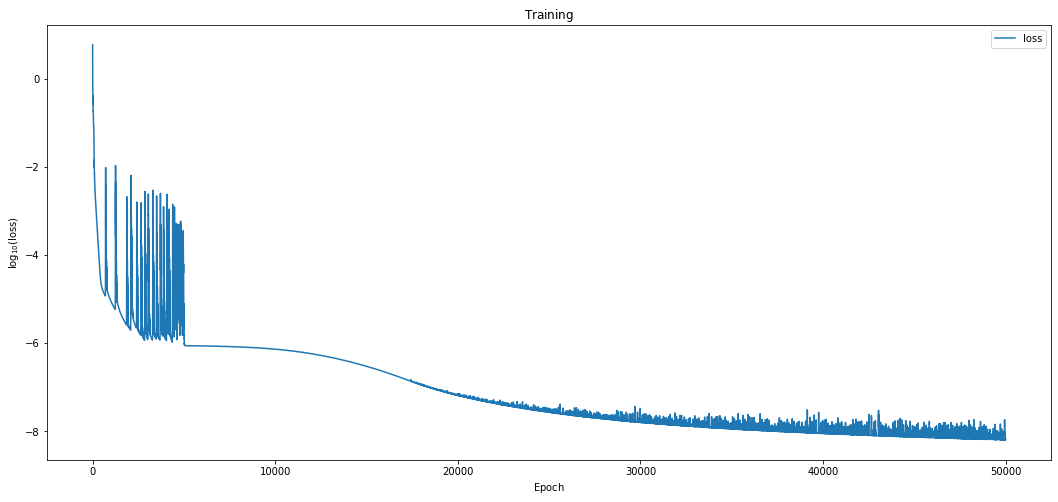

In [11]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18, 8.0)
__ = ax.plot(numpy.log10(loss_history))
xlabel = ax.set_xlabel(r'${\rm Epoch}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss'])
matplotlib.pyplot.savefig('./Images/loss_function.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Load best params of the training

In [12]:
params = pickle.load(open("./Checkpoints/params_pde8", "rb"))

# Approximated solution plot

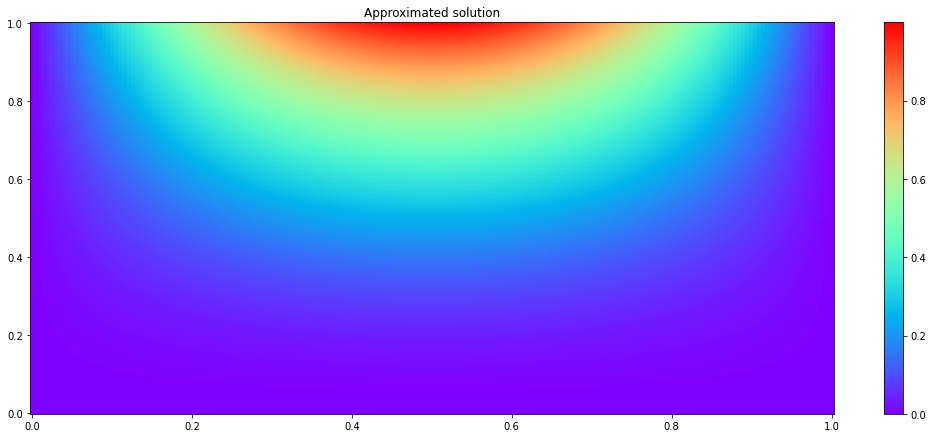

In [17]:
npoints = 200
values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots(1,1)
fig.set_size_inches(18, 7.2)

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = solver.spatial_solution2d(params, x[i,:], y[i,:])[:,0]

title = ax.set_title('Approximated solution')
graph = ax.pcolormesh(x, y, values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax)

matplotlib.pyplot.savefig('./Images/approximated_pde8.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Analytical solution plot

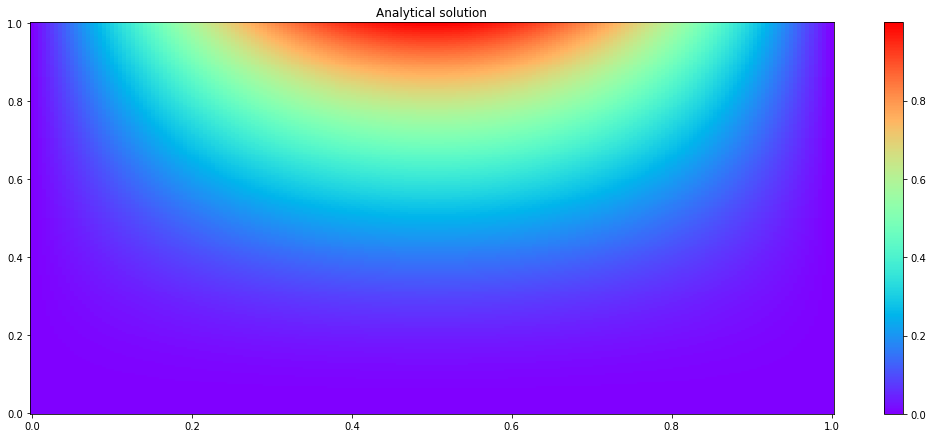

In [19]:
npoints = 200
values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots(1,1)
fig.set_size_inches(18, 7.2)

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = analytical_solution(jax.numpy.column_stack((x[i,:], y[i,:])))

title = ax.set_title('Analytical solution')
graph = ax.pcolormesh(x, y, values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax)

matplotlib.pyplot.savefig('./Images/analytical_pde8.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Squared error plot

MSE:  2.914988417772508e-11


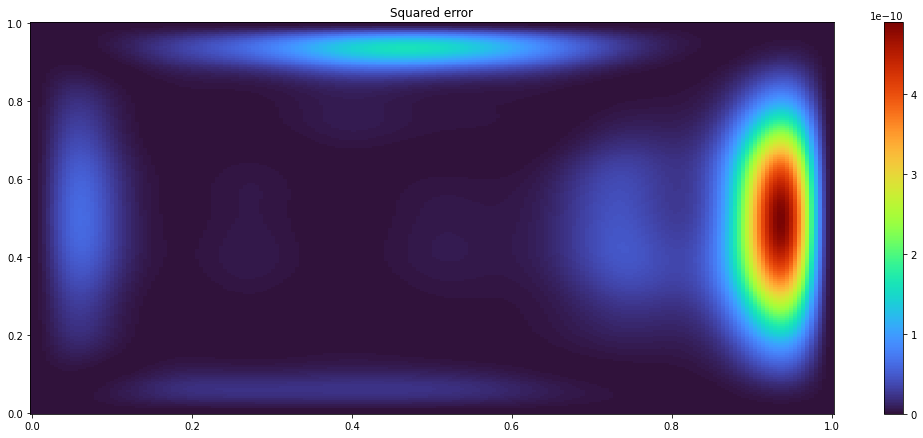

In [15]:
npoints = 200
values = numpy.zeros((npoints, npoints))

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints), numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))

fig, ax = matplotlib.pyplot.subplots(1,1)
fig.set_size_inches(18, 7.2)

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = (solver.spatial_solution2d(params, x[i,:], y[i,:])[:,0] - analytical_solution(jax.numpy.column_stack((x[i,:], y[i,:]))))**2

title = ax.set_title('Squared error')
graph = ax.pcolormesh(x, y, values, cmap = 'turbo')
matplotlib.pyplot.colorbar(graph, ax=ax)
   
print("MSE: ", numpy.mean(values.flatten()))
matplotlib.pyplot.savefig('./Images/squared_error_pde8.png', facecolor = 'white', bbox_inches = 'tight')
matplotlib.pyplot.show()  